#### Transfer Learning Inception V3 using Keras

Please download the dataset from the below url

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
#from keras.applications.vgg16 import VGG16

from keras.applications import imagenet_utils
from keras.applications import resnet
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# isort: off
from tensorflow.python.util.tf_export import keras_export

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS =25

In [ ]:
import tensorflow as tf

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML/3types Lungs Disease",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3986 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal']

In [ ]:
import matplotlib.pyplot as plt

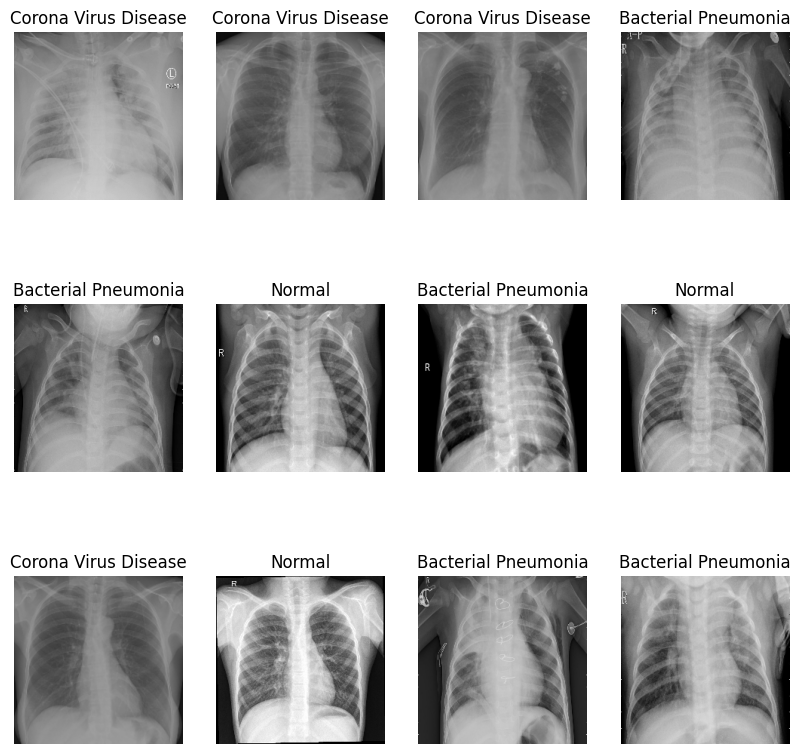

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

125

In [ ]:
train_size =0.8
len(dataset)*train_size

100.0

In [ ]:
train_ds = dataset.take(100)
len(train_ds)

100

In [ ]:
test_ds=dataset.skip(100) 
len(test_ds)

25

In [ ]:
val_size = 0.1
len(dataset)*val_size

12.5

In [ ]:
val_ds=test_ds.take(12)
len(val_ds)

12

In [ ]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):

  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds =ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds


In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

100

In [ ]:
len(val_ds)

12

In [ ]:
len(test_ds)

13

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
image_size=[224,224]

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/223)  
])


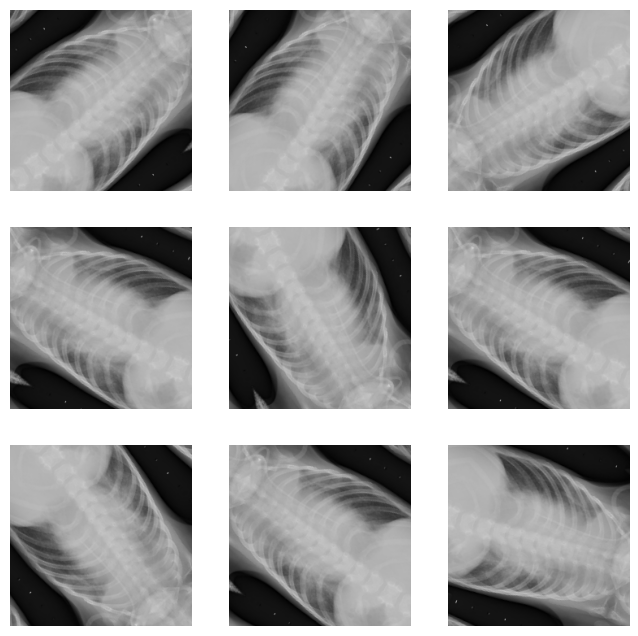

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(8,8))
for images, labels in test_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax=plt.subplot(3,3,i+1)

    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of Resnet152V2
# Here we will be using imagenet weights

resnet152V2 =tf.keras.applications.ResNet152V2(input_shape=image_size+[3], weights='imagenet', include_top=False)




234545216/234545216 [==============================] - 11s 0us/step


In [ ]:
# don't train existing weights
for layer in resnet152V2.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/ML/3types Lungs Disease/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet152V2.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [ ]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/25
100/100 [==============================] - 165s 1s/step - loss: 1499.6637 - accuracy: 0.7433 - val_loss: 526.6644 - val_accuracy: 0.7604
Epoch 2/25
100/100 [==============================] - 26s 262ms/step - loss: 234.6957 - accuracy: 0.8716 - val_loss: 65.6089 - val_accuracy: 0.9453
Epoch 3/25
100/100 [==============================] - 28s 276ms/step - loss: 148.3057 - accuracy: 0.9083 - val_loss: 113.0952 - val_accuracy: 0.9089
Epoch 4/25
100/100 [==============================] - 28s 279ms/step - loss: 145.4698 - accuracy: 0.9071 - val_loss: 264.0968 - val_accuracy: 0.8438
Epoch 5/25
100/100 [==============================] - 25s 252ms/step - loss: 210.3685 - accuracy: 0.8883 - val_loss: 464.0265 - val_accuracy: 0.8073
Epoch 6/25
100/100 [==============================] - 26s 256ms/step - loss: 211.1665 - accuracy: 0.9008 - val_loss: 86.7256 - val_accuracy: 0.9531
Epoch 7/25
100/100 [==============================] - 25s 252ms/step - loss: 340.0979 - accuracy: 0.8867 - va

In [ ]:
scores1=model.evaluate(train_ds)

100/100 [==============================] - 22s 223ms/step - loss: 83.0453 - accuracy: 0.9699


In [ ]:
scores2=model.evaluate(test_ds)

13/13 [==============================] - 3s 218ms/step - loss: 62.0089 - accuracy: 0.9856


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 100}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

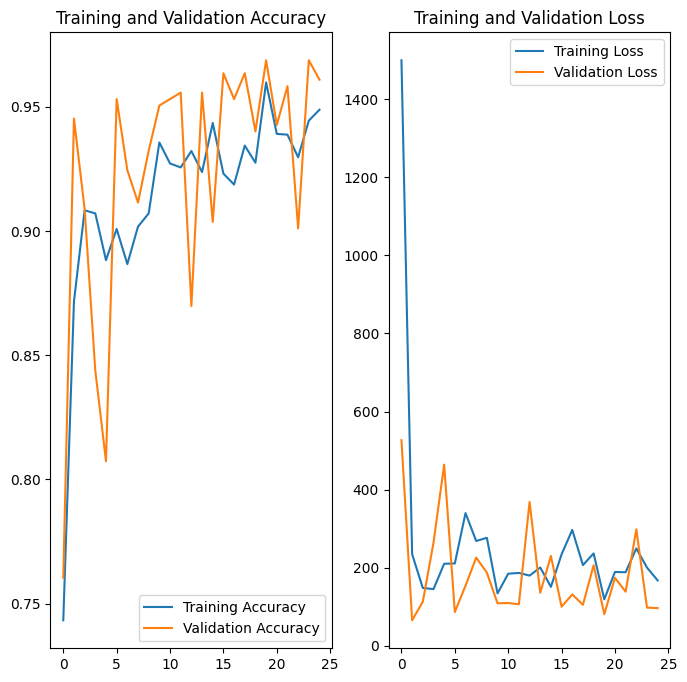

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

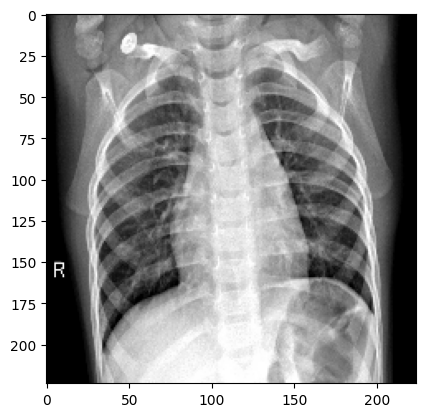

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  print(images_batch[0].numpy().astype('uint8'))

[[[125 125 125]
  [130 130 130]
  [147 147 147]
  ...
  [103 103 103]
  [119 119 119]
  [121 121 121]]

 [[ 84  84  84]
  [ 78  78  78]
  [ 86  86  86]
  ...
  [114 114 114]
  [111 111 111]
  [112 112 112]]

 [[ 80  80  80]
  [ 67  67  67]
  [ 86  86  86]
  ...
  [134 134 134]
  [134 134 134]
  [133 133 133]]

 ...

 [[ 11  11  11]
  [ 14  14  14]
  [ 18  18  18]
  ...
  [202 202 202]
  [201 201 201]
  [ 30  30  30]]

 [[  2   2   2]
  [ 17  17  17]
  [ 18  18  18]
  ...
  [195 195 195]
  [193 193 193]
  [  8   8   8]]

 [[ 16  16  16]
  [  9   9   9]
  [ 18  18  18]
  ...
  [189 189 189]
  [174 174 174]
  [ 60  60  60]]]


first image to predict
first image's actual label: Normal
1/1 [==============================] - 0s 54ms/step
predicted label: Normal


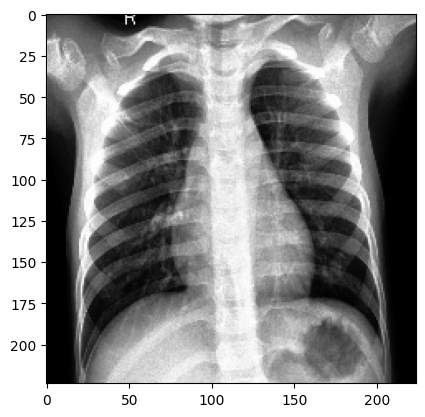

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


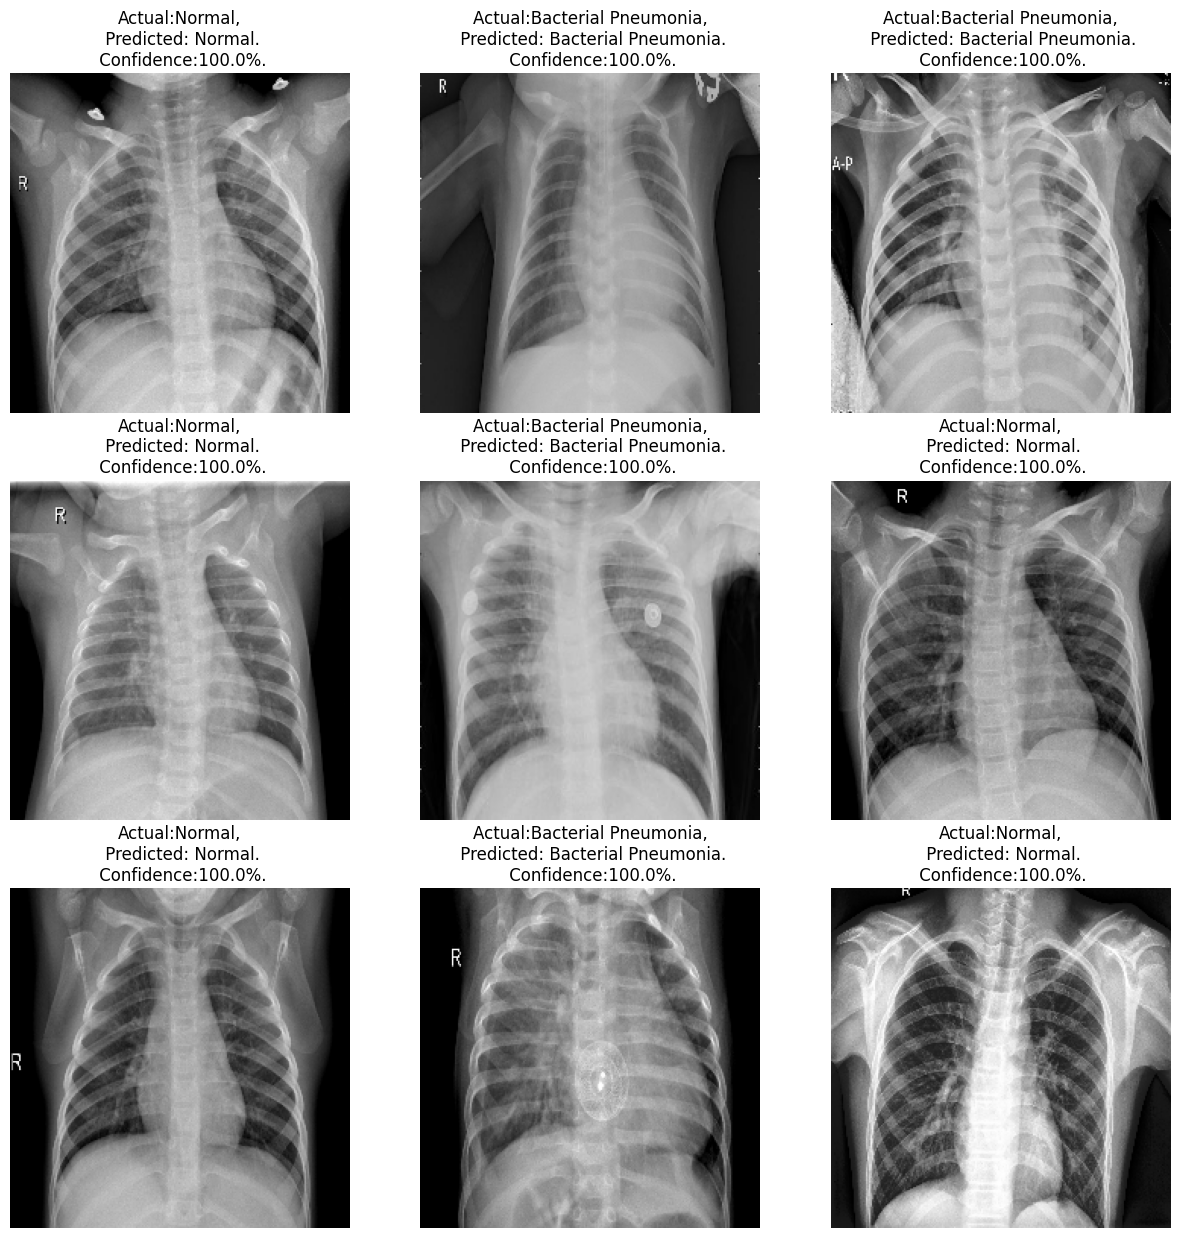

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%.")
    plt.axis("off")

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet152V2.h5')

In [ ]:
tf.__version__

'2.12.0'